In [16]:
import pandas as pd
import numpy as np
import ast
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report

import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/lokkit/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lokkit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lokkit/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
def filter_zero_support_labels(X, y):
    """Remove labels that have 0 total support across all samples"""
    label_counts = y.sum(axis=0)
    nonzero_indices = np.where(label_counts > 0)[0]
    print(f"Keeping {len(nonzero_indices)} of {y.shape[1]} labels (nonzero support).")
    return X, y[:, nonzero_indices], nonzero_indices

In [18]:
from sklearn.metrics import f1_score
def optimize_global_threshold_for_f1(y_true, y_proba, average='micro'):
    """
    Searches a single threshold t that maximizes the *average F1* (macro or micro) across all classes.

    y_true: 2D array, shape (n_samples, n_classes), true 0/1 labels
    y_proba: 2D array, shape (n_samples, n_classes), predicted probabilities
    average: 'micro' or 'macro' (or 'weighted') for how to aggregate F1

    Returns:
      best_thr: float, the single best threshold
      best_score: float, the F1 score achieved at that threshold
    """
    thresholds = np.linspace(0.1, 0.9, 101)  # e.g. 0.00, 0.01, ..., 1.00
    best_score = -1.0
    best_thr = 0.5
    best_thresholds = []
    for i in range(y_true.shape[1]):
      thresholds = np.linspace(0.1, 0.9, 101)
      best_t = 0.5
      best_score = -1
      for t in thresholds:
          # Binarize all classes at once
          test_thresholds = np.ones(y_true.shape[1]) * 0.5
          test_thresholds[i] = t
          y_pred = (y_proba >= test_thresholds).astype(int)
          # Compute F1 across *all* classes
          micro_score = f1_score(y_true, y_pred, average='micro', zero_division=0)
          macro_score = f1_score(y_true, y_pred, average='macro', zero_division=0)
          weighted_score = f1_score(y_true, y_pred, average='weighted', zero_division=0)
          score = np.mean([macro_score])  # Average of all F1s
          if score > best_score:
              best_score = score
              best_t = t
      best_thresholds.append(best_t)
    best_thresholds = np.array(best_thresholds)
    return best_thresholds, best_score

In [19]:
# 📄 Step 2: Load Data
df = pd.read_csv("proper_df (7).csv")

# Combine intro + conclusion
df["combined_text"] = df["abstract_section"] + " " + df["section"]

In [20]:
# 🧹 Step 3: Preprocess Text
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]  # remove punctuation/numbers
    tokens = [t for t in tokens if t not in stop_words]
    lemmatized = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(lemmatized)

df["clean_text"] = df["combined_text"].apply(preprocess)

In [21]:
# 🎯 Step 4: Parse Labels
# Convert labels from string to array
df["labels"] = df["model_family_vector"].apply(ast.literal_eval)

In [22]:
# 🔍 Step 5: TF-IDF Vectorization
ngram = (1,1)
tfidf = TfidfVectorizer(max_features=175, ngram_range=ngram,)
X_tfidf = tfidf.fit_transform(df["clean_text"])
X_final = X_tfidf

y = np.array(df["labels"].tolist())

# Remove labels with zero support
_, y_filtered, nonzero_label_indices = filter_zero_support_labels(X_tfidf, y)

Keeping 16 of 16 labels (nonzero support).


In [23]:
# ✂️ Step 7: Train/Test Split
y = np.array(df["labels"].tolist())
X_train, X_test, y_train, y_test = train_test_split(X_final, y_filtered, test_size=0.2, random_state=42)

In [24]:
from sklearn.metrics import f1_score, accuracy_score
# 🧠 Step 8: Naive Bayes Model (Multi-label with OneVsRest)
nb_clf = OneVsRestClassifier(MultinomialNB(alpha=0.8))
nb_clf.fit(X_train, y_train)

# 📈 Step 9: Predict + Evaluate
y_pred = nb_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# ✅ Check if your model supports predict_proba
print(hasattr(nb_clf, "predict_proba"))  # Should print True

# 🧪 Step 10: Get probabilities
y_proba = nb_clf.predict_proba(X_test)

# Before threshold optimization
print("=== Raw Predictions ===")
print("F1 Micro:", f1_score(y_test, y_pred, average='micro', zero_division=0))
print("F1 Macro:", f1_score(y_test, y_pred, average='macro', zero_division=0))
print("Exact Match:", accuracy_score(y_test, y_pred))

# 🔍 Step 11: Optimize thresholds + evaluate again
best_thresholds, score = optimize_global_threshold_for_f1(y_test, y_proba)
y_pred_optimized = (y_proba >= best_thresholds).astype(int)
print(classification_report(y_test, y_pred_optimized))

# After threshold optimization
print("=== Threshold-Optimized Predictions ===")
print("F1 Micro:", f1_score(y_test, y_pred_optimized, average='micro', zero_division=0))
print("F1 Macro:", f1_score(y_test, y_pred_optimized, average='macro', zero_division=0))
print("Exact Match:", accuracy_score(y_test, y_pred_optimized))


              precision    recall  f1-score   support

           0       1.00      0.07      0.12        15
           1       0.00      0.00      0.00        14
           2       1.00      0.14      0.25         7
           3       0.75      0.20      0.32        15
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00        10
           7       0.00      0.00      0.00        16
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         3
          11       1.00      0.19      0.32        16
          12       0.00      0.00      0.00         0
          13       1.00      0.05      0.09        21
          14       0.00      0.00      0.00         0
          15       1.00      0.24      0.38        17

   micro avg       0.93      0.09      0.16       149
   macro avg       0.36   

/opt/homebrew/Caskroom/miniconda/base/envs/ml_hw2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/ml_hw2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/ml_hw2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

              precision    recall  f1-score   support

           0       0.45      0.87      0.59        15
           1       0.47      0.64      0.55        14
           2       0.86      0.86      0.86         7
           3       0.53      0.67      0.59        15
           4       0.67      0.20      0.31        10
           5       0.00      0.00      0.00         0
           6       0.40      0.60      0.48        10
           7       0.65      0.81      0.72        16
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         3
          11       0.71      0.62      0.67        16
          12       0.00      0.00      0.00         0
          13       0.80      0.57      0.67        21
          14       0.00      0.00      0.00         0
          15       0.59      0.94      0.73        17

   micro avg       0.57      0.65      0.61       149
   macro avg       0.38   

/opt/homebrew/Caskroom/miniconda/base/envs/ml_hw2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/ml_hw2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/Caskroom/miniconda/base/envs/ml_hw2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _war

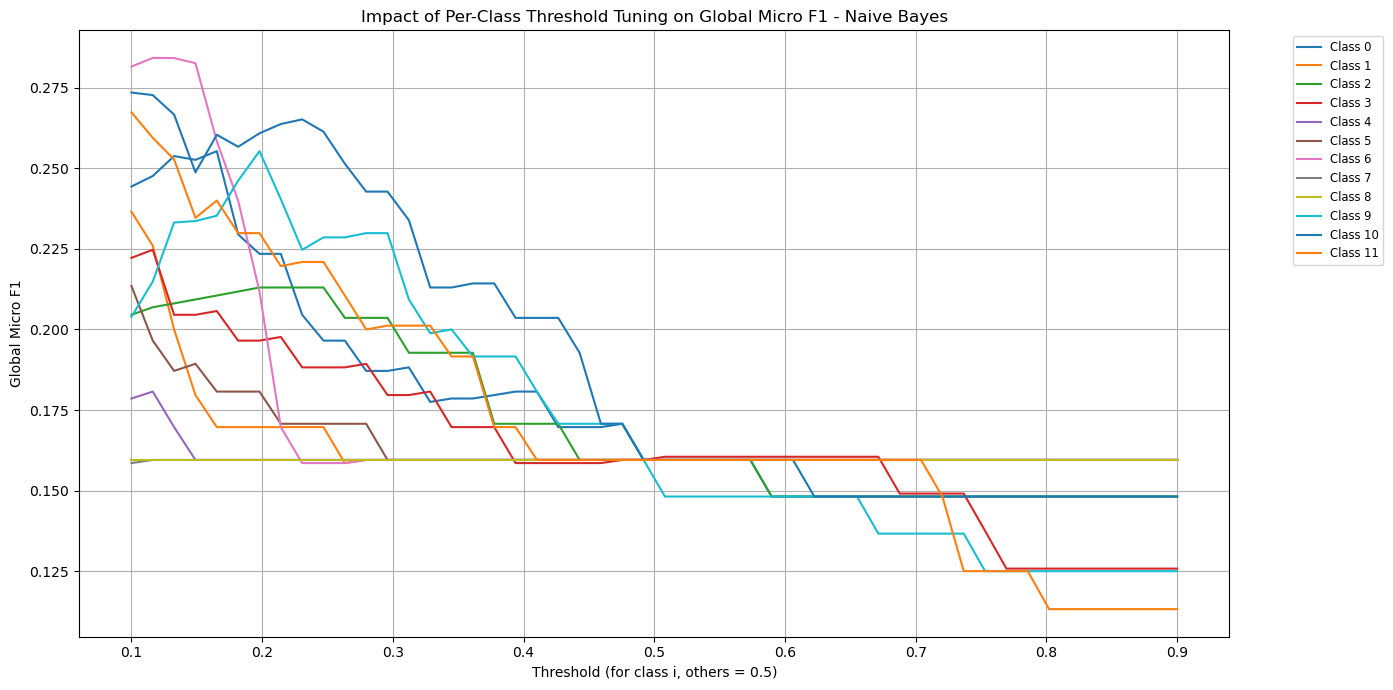

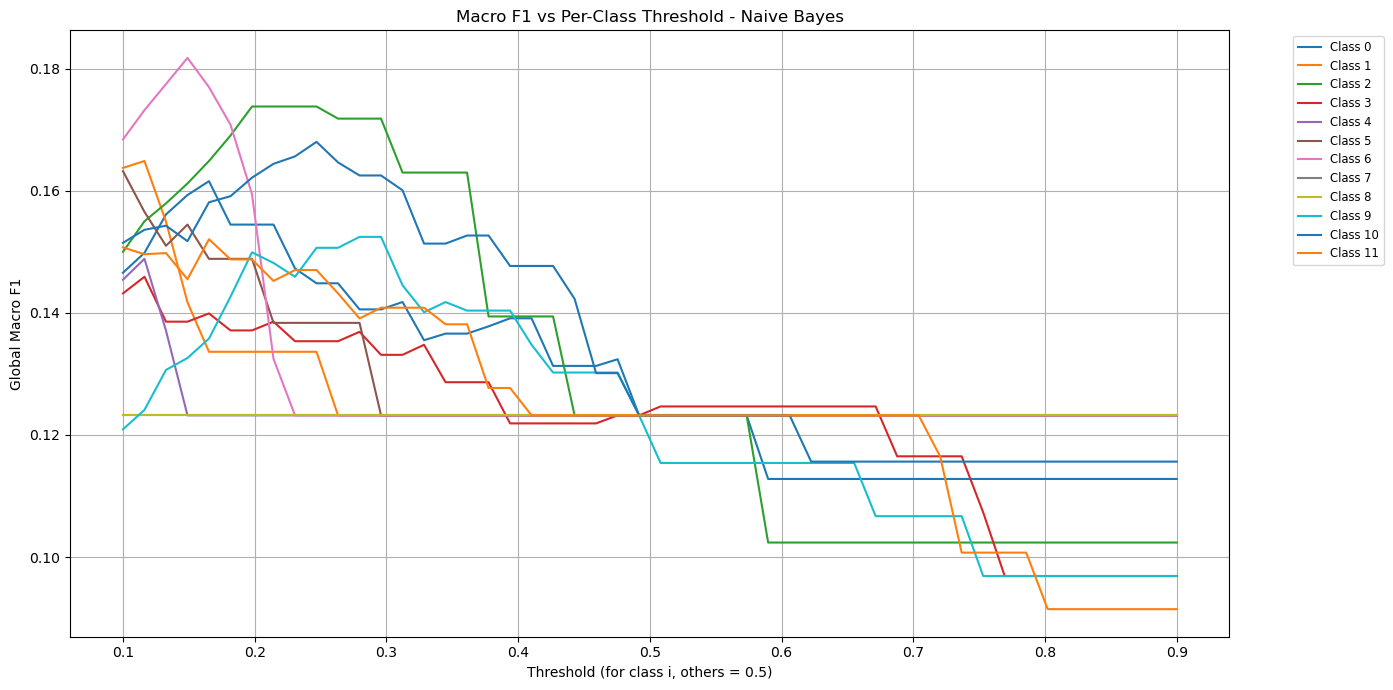

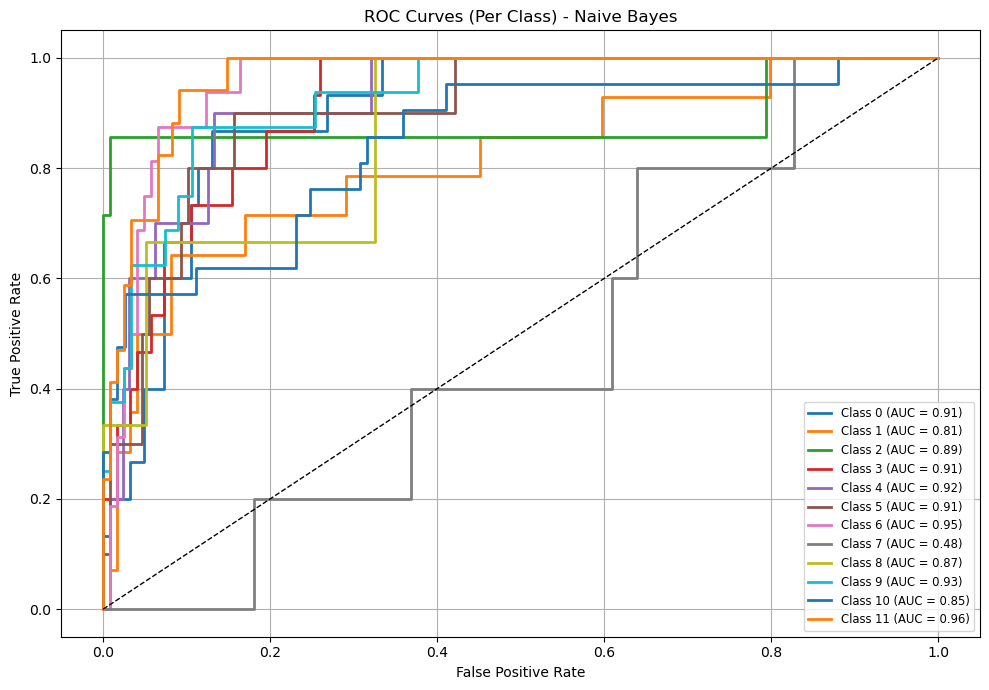

In [29]:
import numpy as np
from sklearn.metrics import f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# Ensure y_test and y_proba are numpy arrays
y_test = np.array(y_test)
y_proba = np.array(y_proba)

# Drop dead columns (e.g., all-zero or all-one labels if needed)
nonzero_label_indices = np.where(y_test.sum(axis=0) != 0)[0]
y_test_filtered = y_test[:, nonzero_label_indices]
y_proba_filtered = y_proba[:, nonzero_label_indices]
label_names = [f"Class {i}" for i in range(y_test_filtered.shape[1])]  # Rename if you have actual names

thresholds = np.linspace(0.1, 0.9, 50)
num_classes = y_test_filtered.shape[1]

# === 1) Micro F1 vs threshold (tuning one class at a time) ===
micro_f1_per_class = []
for i in range(num_classes):
    f1_vals = []
    for t in thresholds:
        temp_thresh = np.ones(num_classes) * 0.5
        temp_thresh[i] = t
        y_pred = (y_proba_filtered >= temp_thresh).astype(int)
        f1_vals.append(f1_score(y_test_filtered, y_pred, average='micro', zero_division=0))
    micro_f1_per_class.append(f1_vals)

# === 2) Macro F1 vs threshold (tuning one class at a time) ===
macro_f1_per_class = []
for i in range(num_classes):
    f1_vals = []
    for t in thresholds:
        temp_thresh = np.ones(num_classes) * 0.5
        temp_thresh[i] = t
        y_pred = (y_proba_filtered >= temp_thresh).astype(int)
        f1_vals.append(f1_score(y_test_filtered, y_pred, average='macro', zero_division=0))
    macro_f1_per_class.append(f1_vals)

# === 3) ROC Curve data (fpr, tpr, auc) per class ===
roc_data_per_class = []
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_test_filtered[:, i], y_proba_filtered[:, i])
    roc_auc = auc(fpr, tpr)
    roc_data_per_class.append({
        "label": label_names[i],
        "fpr": fpr,
        "tpr": tpr,
        "auc": roc_auc
    })

# Now you can plot using plt.plot() for each of these variables:
# - `micro_f1_per_class[i]` vs `thresholds`
# - `macro_f1_per_class[i]` vs `thresholds`
# - `roc_data_per_class[i]['fpr']`, `roc_data_per_class[i]['tpr']`

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
for i, f1_vals in enumerate(micro_f1_per_class):
    plt.plot(thresholds, f1_vals, label=label_names[i])
plt.xlabel("Threshold (for class i, others = 0.5)")
plt.ylabel("Global Micro F1")
plt.title("Impact of Per-Class Threshold Tuning on Global Micro F1 - Naive Bayes")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
for i, f1_vals in enumerate(macro_f1_per_class):
    plt.plot(thresholds, f1_vals, label=label_names[i])
plt.xlabel("Threshold (for class i, others = 0.5)")
plt.ylabel("Global Macro F1")
plt.title("Macro F1 vs Per-Class Threshold - Naive Bayes")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 7))
for class_data in roc_data_per_class:
    plt.plot(class_data["fpr"], class_data["tpr"], lw=2,
             label=f'{class_data["label"]} (AUC = {class_data["auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title("ROC Curves (Per Class) - Naive Bayes")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right", fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()